In [ ]:
project_name = 'human-face-gan'

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [ ]:
import os

DATA_DIR = '/content/drive/MyDrive/Deep Learning Dataset'
print(os.listdir(DATA_DIR))

['cpData-Mar2023']


In [ ]:
print(os.listdir(DATA_DIR + "/cpData-Mar2023")[:10])

['S004.jpg', 'S005.jpeg', 'S006.jpg', 'S002.jpeg', 'S008.jpg', 'S003.jpg', 'S001.jpg', 'S007.jpeg', 'S016.jpg', 'S014.jpeg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

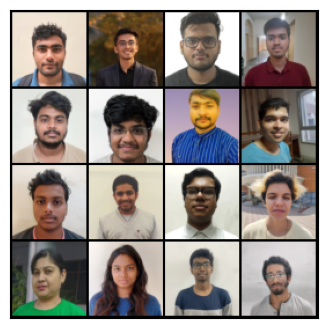

In [ ]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 32

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([16, 3, 64, 64])


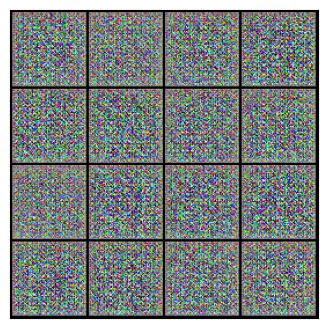

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [ ]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [ ]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


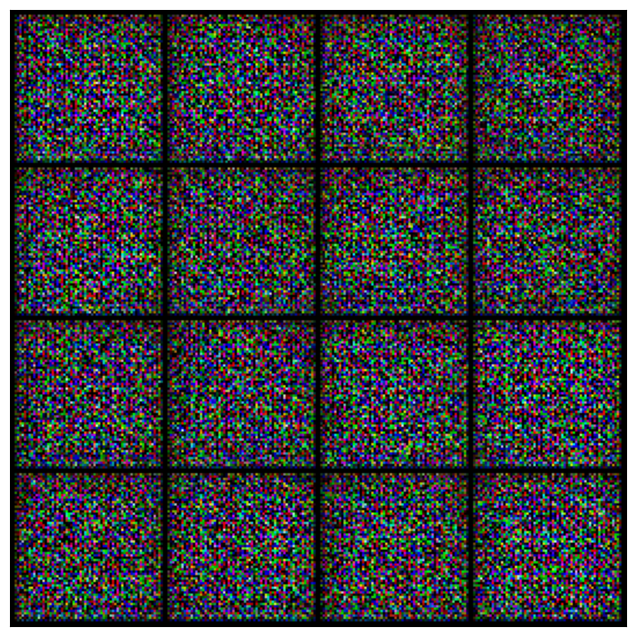

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
# jovian.commit(project=project_name, environment=None)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.3, 0.9))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.3, 0.9))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [ ]:
lr = 0.0002
epochs = 40

In [ ]:
# jovian.reset()
# jovian.log_hyperparams(lr=lr, epochs=epochs)

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 9.9883, loss_d: 0.3101, real_score: 0.9381, fake_score: 0.1989
Saving generated-images-0001.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 9.9837, loss_d: 0.0034, real_score: 0.9968, fake_score: 0.0001
Saving generated-images-0002.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 8.4302, loss_d: 0.0143, real_score: 0.9888, fake_score: 0.0029
Saving generated-images-0003.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 8.8977, loss_d: 0.0700, real_score: 0.9659, fake_score: 0.0319
Saving generated-images-0004.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 7.3839, loss_d: 0.0112, real_score: 0.9894, fake_score: 0.0004
Saving generated-images-0005.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.0267, loss_d: 0.6123, real_score: 0.8468, fake_score: 0.2987
Saving generated-images-0006.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 2.0723, loss_d: 0.3289, real_score: 0.8678, fake_score: 0.1276
Saving generated-images-0007.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 2.7212, loss_d: 0.5921, real_score: 0.8423, fake_score: 0.3210
Saving generated-images-0008.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 3.9690, loss_d: 0.4645, real_score: 0.8154, fake_score: 0.1865
Saving generated-images-0009.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 0.3256, loss_d: 0.7076, real_score: 0.5783, fake_score: 0.0472
Saving generated-images-0010.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 3.5514, loss_d: 0.6338, real_score: 0.8821, fake_score: 0.3764
Saving generated-images-0011.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 3.9244, loss_d: 1.2223, real_score: 0.8367, fake_score: 0.5657
Saving generated-images-0012.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 3.5854, loss_d: 0.5704, real_score: 0.9336, fake_score: 0.3672
Saving generated-images-0013.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 1.8776, loss_d: 0.5333, real_score: 0.6937, fake_score: 0.1236
Saving generated-images-0014.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 5.9558, loss_d: 1.9425, real_score: 0.9701, fake_score: 0.7736
Saving generated-images-0015.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 3.8543, loss_d: 0.9016, real_score: 0.9740, fake_score: 0.5296
Saving generated-images-0016.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 1.9144, loss_d: 0.8184, real_score: 0.5518, fake_score: 0.0555
Saving generated-images-0017.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 6.4392, loss_d: 0.6340, real_score: 0.9625, fake_score: 0.4047
Saving generated-images-0018.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.8477, loss_d: 0.4638, real_score: 0.9480, fake_score: 0.3116
Saving generated-images-0019.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 2.7672, loss_d: 0.6854, real_score: 0.5721, fake_score: 0.0181
Saving generated-images-0020.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 2.8845, loss_d: 0.5997, real_score: 0.7780, fake_score: 0.1929
Saving generated-images-0021.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 2.8008, loss_d: 0.6121, real_score: 0.6065, fake_score: 0.0233
Saving generated-images-0022.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 1.5096, loss_d: 0.4880, real_score: 0.7455, fake_score: 0.1557
Saving generated-images-0023.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 2.4111, loss_d: 0.3072, real_score: 0.8041, fake_score: 0.0716
Saving generated-images-0024.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.5543, loss_d: 0.7666, real_score: 0.9119, fake_score: 0.3927
Saving generated-images-0025.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.1551, loss_d: 0.2825, real_score: 0.8062, fake_score: 0.0514
Saving generated-images-0026.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.6236, loss_d: 0.1966, real_score: 0.8490, fake_score: 0.0268
Saving generated-images-0027.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.5457, loss_d: 0.4486, real_score: 0.9744, fake_score: 0.2854
Saving generated-images-0028.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 2.8706, loss_d: 0.3829, real_score: 0.9512, fake_score: 0.2565
Saving generated-images-0029.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 5.6339, loss_d: 0.4765, real_score: 0.6830, fake_score: 0.0052
Saving generated-images-0030.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 3.7215, loss_d: 0.1266, real_score: 0.9573, fake_score: 0.0739
Saving generated-images-0031.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.4929, loss_d: 0.2694, real_score: 0.8432, fake_score: 0.0564
Saving generated-images-0032.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 3.7575, loss_d: 0.2901, real_score: 0.8528, fake_score: 0.0988
Saving generated-images-0033.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 2.9650, loss_d: 0.5299, real_score: 0.6548, fake_score: 0.0093
Saving generated-images-0034.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 5.2409, loss_d: 0.3756, real_score: 0.9823, fake_score: 0.2448
Saving generated-images-0035.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 5.7233, loss_d: 0.0875, real_score: 0.9460, fake_score: 0.0284
Saving generated-images-0036.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.9085, loss_d: 0.2016, real_score: 0.8407, fake_score: 0.0111
Saving generated-images-0037.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 2.9754, loss_d: 0.1943, real_score: 0.8849, fake_score: 0.0590
Saving generated-images-0038.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 5.6752, loss_d: 0.2090, real_score: 0.9440, fake_score: 0.1260
Saving generated-images-0039.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 4.3572, loss_d: 0.2722, real_score: 0.8434, fake_score: 0.0740
Saving generated-images-0040.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# jovian.log_metrics(loss_g=losses_g[-1], 
#                    loss_d=losses_d[-1], 
#                    real_score=real_scores[-1], 
#                    fake_score=fake_scores[-1])

Now that we have trained the models, we can save checkpoints.

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [ ]:
from IPython.display import Image

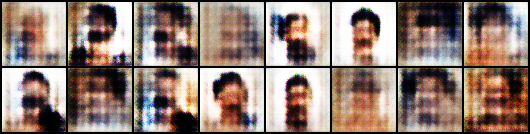

In [ ]:
Image('./generated/generated-images-0010.png')

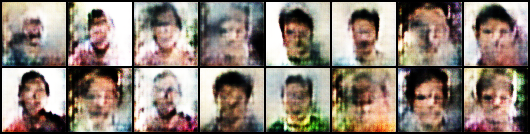

In [ ]:
Image('./generated/generated-images-0020.png')

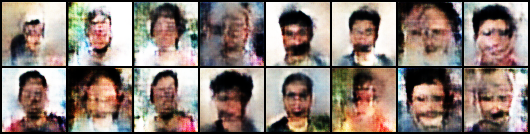

In [ ]:
Image('./generated/generated-images-0030.png')

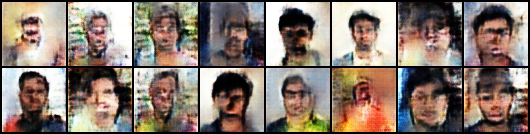

In [ ]:
Image('./generated/generated-images-0040.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



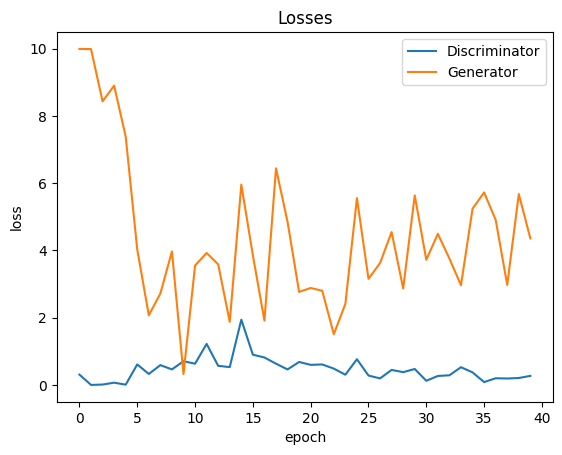

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

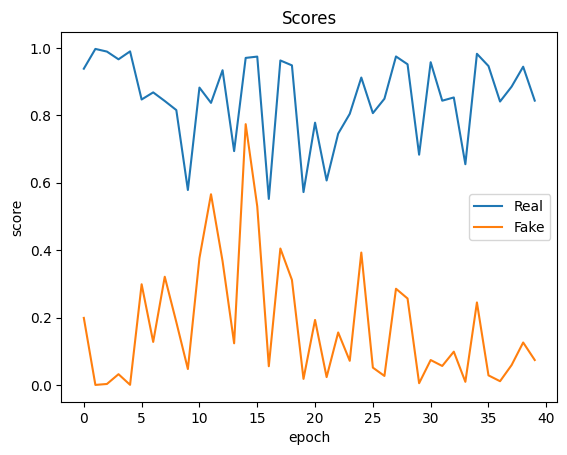

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');